In [1]:
# Import libraries and stuff
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

Could not import packages for CMIknn and GPDC estimation
Could not import rpy package
Could not import r-package RCIT


In [2]:
# Synthetic data definition: 
# 4 nodes (4 variables)
# time series are autocorrelated
# linear relationships

np.random.seed(1)
# data_t has 1010 data points. I then remove a transient of 10 points to define "data"
data_t = np.random.randn(1010, 4)

# process definition
for t in range(4, 1010):
    data_t[t, 0] += 0.8*data_t[t-1, 0]
    data_t[t, 1] += 0.4*data_t[t-1, 1] + 0.6*data_t[t-3, 2] - 0.3*data_t[t-1, 3]
    data_t[t, 2] += 0.6*data_t[t-1, 2] + 0.9*data_t[t-1, 0]
    data_t[t, 3] += 0.5*data_t[t-1, 3] + 0.4*data_t[t-2, 0]

In [3]:
# remove the transient
data = data_t[10:]

In [4]:
T = len(data)     # time series length
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names)

Text(0.5, 1.0, 'x_3')

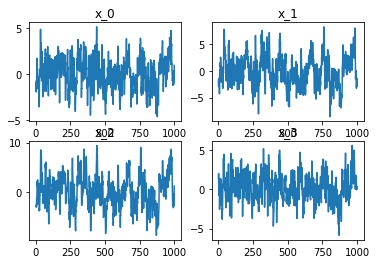

In [5]:
# Let's give a look to the 4 time series
timeSeries = np.transpose(data)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(timeSeries[0])
ax1.set_title('x_0')

ax2 = plt.subplot(2, 2, 2)
ax2.plot(timeSeries[1])
ax2.set_title('x_1')

ax3 = plt.subplot(2, 2, 3)
ax3.plot(timeSeries[2])
ax3.set_title('x_2')

ax4 = plt.subplot(2, 2, 4)
ax4.plot(timeSeries[3])
ax4.set_title('x_3') 

In [6]:
# Relationships here are linear. We test the inference with parCorr.
# With significance='analytic' the null distribution is assumed to be Student's $t$.
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
     verbosity=1)

In [7]:
# Format of the data is (number of points in time, number of variables)
# If it is the opposite REMEMBER TO TRANSPOSE THEM to have this format.
np.shape(data)

(1000, 4)

In [7]:
######################### STEP 1 #########################

# I choose tau_max=8 for PCMCI.
# pc_alpha is the significance level for the statistical test
# we let the algorithm choose for it using the Akaike Information
# criterion among a reasonable default list of values (0.05, 0.1, 0.2, 0.3, 0.4, 0.5)

results = pcmci.run_pcmci(tau_max=8, max_combinations=10, pc_alpha=None)


##
## Running Tigramite PC algorithm
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = None
max_conds_dim = None
max_combinations = 10



## Variable $X^0$

## Variable $X^1$

## Variable $X^2$

## Variable $X^3$

## Resulting condition sets:

    Variable $X^0$ has 3 parent(s):
    [pc_alpha = 0.4]
        ($X^0$ -1): max_pval = 0.00000, min_val = 0.630
        ($X^0$ -4): max_pval = 0.29603, min_val = 0.033
        ($X^1$ -3): max_pval = 0.34806, min_val = 0.030

    Variable $X^1$ has 4 parent(s):
    [pc_alpha = 0.5]
        ($X^2$ -3): max_pval = 0.00000, min_val = 0.412
        ($X^1$ -1): max_pval = 0.00000, min_val = 0.340
        ($X^3$ -1): max_pval = 0.07620, min_val = 0.057
        ($X^0$ -8): max_pval = 0.46406, min_val = 0.023

    Variable $X^2$ has 3 parent(s):
    [pc_alpha = 0.4]
        ($X^2$ -1): max_pval = 0.00000, min_val = 0.597
        ($X^0$ -1): max_pval = 0.00000, min_val = 0.539
        ($X^1$ -6): max_pval = 0.33976, min_val 

In [8]:
######################### STEP 2 #########################

# We performed (N * \tau_max) tests for statistical 
# significance. We are going to have False Positives. 
# Therefore we want to control the False Discovery Rate: let's use FDR.
# We set the alpha_level to 0.01 ---> at most 1% of the links we find are
# going to be False Positives (on average).

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 1 link(s):
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.626

    Variable $X^1$ has 3 link(s):
        ($X^2$ -3): pval = 0.00000 | qval = 0.00000 | val = 0.507
        ($X^1$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.357
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = -0.310

    Variable $X^2$ has 2 link(s):
        ($X^0$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.674
        ($X^2$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.508

    Variable $X^3$ has 2 link(s):
        ($X^3$ -1): pval = 0.00000 | qval = 0.00000 | val = 0.492
        ($X^0$ -2): pval = 0.00000 | qval = 0.00000 | val = 0.355
